In [1]:
import pandas as pd
from db import Database
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
import matplotlib.colors as mpcolors
import numpy as np
import seaborn as sns

db = Database()

In [2]:

def get_df(db: Database, mwname, pcap_id, g: bool, pt: str, slot_h=1.0, nn=1, max_slots_h=0):

    if g:
        if pt == 'q':
            where = 'rn_qr=1 and is_r is false'
        elif pt == 'r':
            where = 'rn_qr=1 and is_r is true'
        elif pt == 'ok':
            where = 'rn_qr_rcode=1 and rcode = 0'
        elif pt == 'nx':
            where = 'rn_qr_rcode=1 and rcode = 3'
    else:
        if pt == 'q':
            where = 'is_r is false'
        elif pt == 'r':
            where = 'is_r is true'
        elif pt == 'ok':
            where = 'rcode = 0'
        elif pt == 'nx':
            where = 'rcode = 3'


    slot_seconds = 3600 * slot_h
    upper_where = ''
    if max_slots_h > 0:
        max_slots_time = max_slots_h/slot_h
        upper_where = f' and FLOOR(time_s_translated / {slot_seconds}) < {max_slots_time}'
        pass

    if pcap_id:
        df = pd.read_sql(f"""
        SELECT EPS{nn} < 0.5 AS pn, EPS{nn} >= 0.5 AS pp, time_s_translated, FLOOR(time_s_translated / {slot_seconds}) as "hour" from public.get_message_pcap_all3({pcap_id},0)
        where {where} {upper_where}
        """, db.engine)
    else:
        df = pd.read_sql(f"""
        SELECT EPS{nn} < 0.5 AS pn, EPS{nn} >= 0.5 AS pp, time_s_translated, FLOOR(time_s_translated / {slot_seconds}) as "hour" from public.get_message_healthy_all2()
        where {where} {upper_where}
        """, db.engine)

    df = df.groupby("hour").aggregate({"pn": "sum", "pp": 'sum'})

    df.index.name = 'slot'

    df.index = df.index - df.index.min()

    df = df.reindex(pd.Index(range(int(df.index.max()))), fill_value=0)

    df.index.name = 'slot'

    df = df.reset_index()

    if any(df.slot.value_counts() > 1):
        raise Exception('Some values are duplicated.')
    
    return df

In [3]:
dfh = get_df(db, 'healthy', None, True, 'nx', slot_h=1)
DFH = dfh[dfh.slot < 8].copy()
dfs = {
    'caphaw': get_df(db, 'caphaw', 54, True, 'nx', slot_h=1),
    'zbot': get_df(db, 'zbot', 46, True, 'nx', slot_h=1),
    'simda': get_df(db, 'simda', 58, True, 'nx', slot_h=1),
    'unknown': get_df(db, 'unknown', 57, True, 'nx', slot_h=1)
}
mws = list(dfs.keys())

In [83]:

def bo(df_mw, dfh_or, th_p=1.0, normal = None):
    th = dfh_or['pp'].max() * th_p
    values = []
    for i in range(len(df_mw) - 8):
        dfm = df_mw.iloc[i:i+8].reset_index(drop=True)
        dfh = dfh_or.copy()

        if normal is not None:
            muls = np.ceil(normal[i:i+8])
            muls[muls<0] = 0
            dfh['pp'] *= pd.Series(muls)
            pass

        df = (dfh + dfm)['pp']

        fps0 = (dfh['pp'] > th)
        n0 = (dfh['pp'] > 0)

        fps = (dfm['pp'] == 0) & (df > th)
        tps = (dfm['pp'] > 0) & (df > th)

        na = (dfm['pp'] == 0).sum()
        pa = (dfm['pp'] > 0).sum()
        
        tp_slotpairgroup = (tps.sum() > 0) and (dfm['pp'].sum() > 0)

        values.append([ fps0.sum(), n0.sum(), fps.sum(), tps.sum(), na, pa, tp_slotpairgroup ])
        pass
    df = pd.DataFrame(values, columns=['fp0-slotpair', 'n0-slotpair', 'fp-slotpair', 'tp-slotpair', 'n-slotpair', 'p-slotpair', 'tp-slotpairgroup'])
    return df

In [169]:
muh = dfh[dfh['pp'] > 0]['pp'].mean()
sigmas = [
    dict(th_p=1., mu=0, sigma=0.0),
    dict(th_p=1, mu=1.0, sigma=muh),
    dict(th_p=1.5, mu=1.0, sigma=muh),
    dict(th_p=1, mu=1.0, sigma=muh * 0.5),
    dict(th_p=70 * 1.5, mu=70.0, sigma=70 * muh * 0.5)
]

def print_sigmas(sigmas):
    v = []
    id = []
    for i, sigma in enumerate(sigmas):
        # print(rf"""\item $\gamma^{i}$: $\beta_{{t_s}}={sigma['th_p']}$,
                # $\mu={sigma['mu']}$, $\sigma={sigma['th_p']}$.""")
        v.append([ sigma['th_p'], sigma['mu'], sigma['sigma']])
        id.append(r'$\gamma^{i}$')

    return pd.DataFrame(v, columns=[r'$\beta_{t_s}$', r'$\mu=0$', r'$\sigma=1.0$'], index=id)#.to_clipboard()

In [187]:

def perform(sigmas, N=100):
    v = []
    for n in range(N):
        for idxsigma, sigma in enumerate(sigmas):
            normal = None
            if sigma['sigma'] > 0:
                normal = np.random.normal(sigma['mu'], sigma['sigma'], 50)

            for mwidx, mw in enumerate(mws):

                df = dfs[mw]

                df = bo(df.copy(), DFH.copy(), sigma['th_p'], normal)

                df = df.iloc[0:50]

                df['FPR0-slotpair'] = df['fp0-slotpair'] / df['n0-slotpair']
                df['FPR-slotpair'] = df['fp-slotpair'] / df['n-slotpair']
                df['TPR-slotpair'] = df['tp-slotpair'] / df['p-slotpair']

                tot_fp_slotpair = df['fp-slotpair'].sum()
                tot_fn_slotpair = df['p-slotpair'].sum() - df['tp-slotpair'].sum()

                tot_tp_slotpairgroup = df['tp-slotpairgroup'].sum()
                tot_fn_slotpairgroup = df.shape[0] - df['tp-slotpairgroup'].sum()

                def only_not_nan(s):
                    return s[s.between(0,1,inclusive='both')]

                FPR0_mean = only_not_nan(df['FPR0-slotpair']).mean()

                FPR_mean = only_not_nan(df['FPR-slotpair']).mean()
                FPR_max = only_not_nan(df['FPR-slotpair']).max()
                FPR_min = only_not_nan(df['FPR-slotpair']).min()

                TPR_mean = only_not_nan(df['TPR-slotpair']).mean()
                TPR_max = only_not_nan(df['TPR-slotpair']).max()
                TPR_min = only_not_nan(df['TPR-slotpair']).min()

                v.append([
                    n,
                    f"th_p={sigma['th_p']}, mu={sigma['mu']}, sigma={sigma['sigma']}",
                    mw,
                    round(FPR0_mean, 2),
                    round(FPR_mean, 2),
                    round(FPR_max, 2),
                    round(FPR_min, 2),
                    round(TPR_mean, 2),
                    round(TPR_max, 2),
                    round(TPR_min, 2),
                    tot_fp_slotpair,
                    df['n-slotpair'].sum(),
                    tot_fn_slotpair,
                    df['p-slotpair'].sum(),
                    tot_fn_slotpairgroup,
                    df.shape[0],
                    tot_tp_slotpairgroup/df.shape[0]
                ])

                pass
            pass
        DF = pd.DataFrame(v, columns=[
            'N',
            "sigma",
            "mw",
            "mean-ratio-fp0-slotpair-slotpairgroup",
            "mean-ratio-fp-slotpair-slotpairgroup",
            "max-ratio-fp-slotpair-slotpairgroup",
            "min-ratio-fp-slotpair-slotpairgroup",
            "mean-ratio-tp-slotpair-slotpairgroup",
            "max-ratio-tp-slotpair-slotpairgroup",
            "min-ratio-tp-slotpair-slotpairgroup",          
        ] + "tot_fp_slotpair,n-slotpair-count,tot_fn_slotpair,p-slotpair-count,tot_fn_slotpairgroup,slot-group-count,tpr_slotpairgroup".split(','))
        
        return DF.groupby(['N','sigma','mw']).mean().reset_index().drop(columns='N')



In [196]:

def _display(df, sigmas):
    dfsigma_s = []
    dffp_s = []
    for idxsigma, sigma in enumerate(df['sigma'].drop_duplicates()):
        sigma_col_values = [
            'mean-ratio-tp-slotpair-slotpairgroup',
            'n-slotpair-count',
            'tot_fp_slotpair',
            'p-slotpair-count',
            'tot_fn_slotpair',
            'slot-group-count',
            'tot_fn_slotpairgroup',
            'tpr_slotpairgroup'
        ]
        fp_col_values = [
            'mean-ratio-fp0-slotpair-slotpairgroup',
            'tpr_slotpairgroup'
        ]
        dfsigma = df[df.sigma == sigma][['mw'] + sigma_col_values].copy()
        dffp = df[df.sigma == sigma][['mw'] + fp_col_values].copy()

        dfsigma['sigma'] = rf'$\gamma^{idxsigma}$'
        dffp['sigma'] = rf'$\gamma^{idxsigma}$'

        dfsigma_s += [dfsigma]
        dffp_s += [dffp]

        pass

    DFSIGMA = pd.concat(dfsigma_s)
    DFFP = pd.concat(dffp_s)

    DFSIGMA = DFSIGMA.pivot(index='mw', columns='sigma', values=sigma_col_values)

    renamer = {
        'mean-ratio-tp-slotpair-slotpairgroup': r'$\mu(\text{TPR}_g)$',
        'tot_fp_slotpair': r'$\# \text{FP}_p$',
        'tot_fn_slotpair': r'$\# \text{FN}_p$',
        'tot_fn_slotpairgroup': r'$\# \text{FN}_g$ (over 50)'
    }
    display(DFSIGMA)
    print(DFSIGMA.rename(columns=renamer).to_latex(float_format='%.2f'))


    renamer = {
        'mean-ratio-fp0-slotpair-slotpairgroup': r'$\text{FPR}_p$',
        'tpr_slotpairgroup': r'$\text{TPR}_g$',
    }
    DFFP = DFFP.pivot(index='mw', columns='sigma', values=fp_col_values).rename(columns=renamer)

    display(DFFP.loc[:, pd.IndexSlice[r'$\text{FPR}_p$', :]])
    print(DFFP.loc[:, pd.IndexSlice[r'$\text{FPR}_p$', :]].to_latex())
    display(DFFP.loc[:, pd.IndexSlice[r'$\text{TPR}_g$', :]])
    print(DFFP.loc[:, pd.IndexSlice[r'$\text{TPR}_g$', :]].to_latex())
    display(print_sigmas(sigmas))
    pass

In [197]:

muh = dfh[dfh['pp'] > 0]['pp'].mean()
sigmas = [
    dict(th_p=1., mu=0, sigma=0.0),
    dict(th_p=2, mu=2.0, sigma=1),
    dict(th_p=4, mu=2.0, sigma=muh),
    dict(th_p=50 * 1.5, mu=50.0, sigma=25),
    dict(th_p=100 * 1.5, mu=100.0, sigma=25),
]

df = perform(sigmas, N=5)
_display(df, sigmas)

mean-ratio-tp-slotpair-slotpairgroup                                   \
sigma                             $\gamma^0$ $\gamma^1$ $\gamma^2$ $\gamma^3$   
mw                                                                              
caphaw                                  0.45       0.00       0.31       0.12   
simda                                   0.89       0.02       0.81       0.66   
unknown                                 0.84       0.53       0.84       0.76   
zbot                                    0.37       0.00       0.29       0.12   

                   n-slotpair-count                                   \
sigma   $\gamma^4$       $\gamma^0$ $\gamma^1$ $\gamma^2$ $\gamma^3$   
mw                                                                     
caphaw        0.07             16.0       16.0       16.0       16.0   
simda         0.12             76.0       76.0       76.0       76.0   
unknown       0.61            373.0      373.0      373.0      373.0   
zbot          0.10            200.0      200.0      200.0      200.0   

                    ... tot_fn_slotpairgroup                                   \
sigma   $\gamma^4$  ...           $\gamma^0$ $\gamma^1$ $\gamma^2$ $\gamma^3$   
mw                  ...                                                         
caphaw        16.0  ...                  0.0       50.0        3.0       16.0   
simda         76.0  ...                  7.0       44.0        7.0        7.0   
unknown      373.0  ...                 32.0       40.0       32.0       32.0   
zbot         200.0  ...                  5.0       50.0       12.0       30.0   

                   tpr_slotpairgroup                                   \
sigma   $\gamma^4$        $\gamma^0$ $\gamma^1$ $\gamma^2$ $\gamma^3$   
mw                                                                      
caphaw        27.0              1.00       0.00       0.94       0.68   
simda         21.0              0.86       0.12       0.86       0.86   
unknown       37.0              0.36       0.20       0.36       0.36   
zbot          36.0              0.90       0.00       0.76       0.40   

                    
sigma   $\gamma^4$  
mw                  
caphaw        0.46  
simda         0.58  
unknown       0.26  
zbot          0.28  

[4 rows x 40 columns]

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
 & \multicolumn{5}{r}{$\mu(\text{TPR}_g)$} & \multicolumn{5}{r}{n-slotpair-count} & \multicolumn{5}{r}{$\# \text{FP}_p$} & \multicolumn{5}{r}{p-slotpair-count} & \multicolumn{5}{r}{$\# \text{FN}_p$} & \multicolumn{5}{r}{slot-group-count} & \multicolumn{5}{r}{$\# \text{FN}_g$ (over 50)} & \multicolumn{5}{r}{tpr_slotpairgroup} \\
sigma & $\gamma^0$ & $\gamma^1$ & $\gamma^2$ & $\gamma^3$ & $\gamma^4$ & $\gamma^0$ & $\gamma^1$ & $\gamma^2$ & $\gamma^3$ & $\gamma^4$ & $\gamma^0$ & $\gamma^1$ & $\gamma^2$ & $\gamma^3$ & $\gamma^4$ & $\gamma^0$ & $\gamma^1$ & $\gamma^2$ & $\gamma^3$ & $\gamma^4$ & $\gamma^0$ & $\gamma^1$ & $\gamma^2$ & $\gamma^3$ & $\gamma^4$ & $\gamma^0$ & $\gamma^1$ & $\gamma^2$ & $\gamma^3$ & $\gamma^4$ & $\gamma^0$ & $\gamma^1$ & $\gamma^2$ & $\gamma^3$ & $\gamma^4$ & $\gamma^0$ & $\gamma^1$ & $\gamma^2$ & $\gamma^3$ & $\gamma^4$ \\
mw &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &

$\text{FPR}_p$                                            
sigma       $\gamma^0$ $\gamma^1$ $\gamma^2$ $\gamma^3$ $\gamma^4$
mw                                                                
caphaw             0.0        0.0       0.23       0.11       0.12
simda              0.0        0.0       0.23       0.11       0.12
unknown            0.0        0.0       0.23       0.11       0.12
zbot               0.0        0.0       0.23       0.11       0.12

\begin{tabular}{lrrrrr}
\toprule
 & \multicolumn{5}{r}{$\text{FPR}_p$} \\
sigma & $\gamma^0$ & $\gamma^1$ & $\gamma^2$ & $\gamma^3$ & $\gamma^4$ \\
mw &  &  &  &  &  \\
\midrule
caphaw & 0.000000 & 0.000000 & 0.230000 & 0.110000 & 0.120000 \\
simda & 0.000000 & 0.000000 & 0.230000 & 0.110000 & 0.120000 \\
unknown & 0.000000 & 0.000000 & 0.230000 & 0.110000 & 0.120000 \\
zbot & 0.000000 & 0.000000 & 0.230000 & 0.110000 & 0.120000 \\
\bottomrule
\end{tabular}



$\text{TPR}_g$                                            
sigma       $\gamma^0$ $\gamma^1$ $\gamma^2$ $\gamma^3$ $\gamma^4$
mw                                                                
caphaw            1.00       0.00       0.94       0.68       0.46
simda             0.86       0.12       0.86       0.86       0.58
unknown           0.36       0.20       0.36       0.36       0.26
zbot              0.90       0.00       0.76       0.40       0.28

\begin{tabular}{lrrrrr}
\toprule
 & \multicolumn{5}{r}{$\text{TPR}_g$} \\
sigma & $\gamma^0$ & $\gamma^1$ & $\gamma^2$ & $\gamma^3$ & $\gamma^4$ \\
mw &  &  &  &  &  \\
\midrule
caphaw & 1.000000 & 0.000000 & 0.940000 & 0.680000 & 0.460000 \\
simda & 0.860000 & 0.120000 & 0.860000 & 0.860000 & 0.580000 \\
unknown & 0.360000 & 0.200000 & 0.360000 & 0.360000 & 0.260000 \\
zbot & 0.900000 & 0.000000 & 0.760000 & 0.400000 & 0.280000 \\
\bottomrule
\end{tabular}



,$\beta_{t_s}$,$\mu=0$,$\sigma=1.0$
$\gamma^{i}$,1.0,0.0,0.00
$\gamma^{i}$,2.0,2.0,1.00
$\gamma^{i}$,4.0,2.0,1.75
$\gamma^{i}$,75.0,50.0,25.00
$\gamma^{i}$,150.0,100.0,25.00


In [199]:
print(print_sigmas(sigmas).to_latex())

\begin{tabular}{lrrr}
\toprule
 & $\beta_{t_s}$ & $\mu=0$ & $\sigma=1.0$ \\
\midrule
$\gamma^{i}$ & 1.000000 & 0.000000 & 0.000000 \\
$\gamma^{i}$ & 2.000000 & 2.000000 & 1.000000 \\
$\gamma^{i}$ & 4.000000 & 2.000000 & 1.750000 \\
$\gamma^{i}$ & 75.000000 & 50.000000 & 25.000000 \\
$\gamma^{i}$ & 150.000000 & 100.000000 & 25.000000 \\
\bottomrule
\end{tabular}



In [152]:

renamer = {
    'mean-ratio-fp0-slotpair-slotpairgroup': r'$\text{FPR}_p$',
    'tpr_slotpairgroup': r'$\text{TPR}_g$',
}
display(DFFP.pivot(index='mw', columns='sigma', values='mean-ratio-fp0-slotpair-slotpairgroup,tpr_slotpairgroup'.split(',')).rename(columns=renamer))
print(DFFP.pivot(index='mw', columns='sigma', values='mean-ratio-fp0-slotpair-slotpairgroup,tpr_slotpairgroup'.split(',')).rename(columns=renamer).to_csv())

$\text{FPR}_p$                                              \
sigma       $\gamma^0$ $\gamma^1$ $\gamma^2$ $\gamma^3$ $\gamma^4$   
mw                                                                   
caphaw             0.0       0.48       0.48       0.34       0.25   
simda              0.0       0.48       0.48       0.34       0.25   
unknown            0.0       0.48       0.48       0.34       0.25   
zbot               0.0       0.48       0.48       0.34       0.25   

        $\text{TPR}_g$                                              
sigma       $\gamma^0$ $\gamma^1$ $\gamma^2$ $\gamma^3$ $\gamma^4$  
mw                                                                  
caphaw            1.00       0.94       0.92       0.96       0.66  
simda             0.86       0.88       0.86       0.88       0.72  
unknown           0.36       0.36       0.38       0.36       0.20  
zbot              0.90       0.86       0.60       0.84       0.42

,$\text{FPR}_p$,$\text{FPR}_p$,$\text{FPR}_p$,$\text{FPR}_p$,$\text{FPR}_p$,$\text{TPR}_g$,$\text{TPR}_g$,$\text{TPR}_g$,$\text{TPR}_g$,$\text{TPR}_g$
sigma,$\gamma^0$,$\gamma^1$,$\gamma^2$,$\gamma^3$,$\gamma^4$,$\gamma^0$,$\gamma^1$,$\gamma^2$,$\gamma^3$,$\gamma^4$
mw,,,,,,,,,,
caphaw,0.0,0.48,0.48,0.34,0.25,1.0,0.94,0.92,0.96,0.66
simda,0.0,0.48,0.48,0.34,0.25,0.86,0.88,0.86,0.88,0.72
unknown,0.0,0.48,0.48,0.34,0.25,0.36,0.36,0.38,0.36,0.2
zbot,0.0,0.48,0.48,0.34,0.25,0.9,0.86,0.6,0.84,0.42



In [6]:
dfbig = []
for idxsigma, sigma in enumerate(sigmas):
    for mwidx, mw in enumerate(mws):

        df = dfs[mw]

        df = bo(df.copy(), DFH.copy(), sigma['th_p'], sigma['mu'], sigma['sigma'])

        df['sigma'] = idxsigma
        df['mw'] = mw
    
        dfbig.append(df)
        pass
    pass

df = pd.concat(dfbig)

df['ratio-fp-slotpair'] = df['fp-slotpair'] / df['n-slotpair']
df['ratio-tp-slotpair'] = df['tp-slotpair'] / df['p-slotpair']

df['mw'] = pd.CategoricalIndex(df['mw'])
df['sigma'] = pd.CategoricalIndex(df['sigma'])

,fp-slotpair,tp-slotpair,n-slotpair,p-slotpair,tp-slotpairgroup,sigma,mw,ratio-fp-slotpair,ratio-tp-slotpair
0,0,3,0,8,True,0,caphaw,NaN,0.375
1,0,4,0,8,True,0,caphaw,NaN,0.500
2,0,4,0,8,True,0,caphaw,NaN,0.500
3,0,4,0,8,True,0,caphaw,NaN,0.500
4,0,4,0,8,True,0,caphaw,NaN,0.500
...,...,...,...,...,...,...,...,...,...
69,5,1,7,1,True,3,unknown,0.714286,1.000
70,5,1,7,1,True,3,unknown,0.714286,1.000
71,5,1,7,1,True,3,unknown,0.714286,1.000
72,5,1,7,1,True,3,unknown,0.714286,1.000


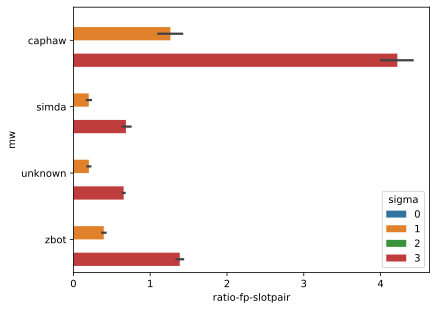

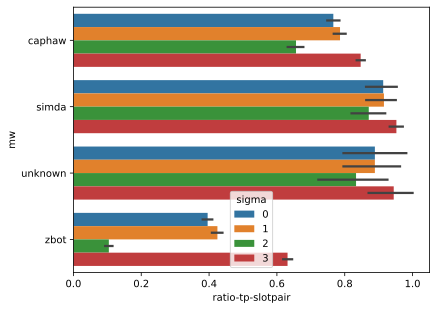

In [26]:

dft = sns.load_dataset("titanic")
# sns.violinplot(data=dft, x="age", y="class")
# sns.violinplot(df.fillna(0), y='mw', x='ratio-fp-slotpair')

plt.figure()
dff = df.copy()
dff = dff[dff['n-slotpair'] > 0]
sns.barplot(dff, y='mw', x='ratio-fp-slotpair', hue='sigma')
dff


plt.figure()
dff = df.copy()
dff = dff[dff['p-slotpair'] > 0]
sns.barplot(dff, y='mw', x='ratio-tp-slotpair', hue='sigma')
dff

NameError: name 'capture' is not defined

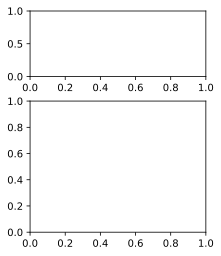

In [33]:

sigmas = [
    dict(th_p=1.0, mu=0, sigma=0.0),
    dict(th_p=1.0, mu=1.0, sigma=0.05),
    dict(th_p=2, mu=1.0, sigma=0.05)
]

fig2 = plt.figure(figsize=( 15, 4 ))
gs2 = fig2.add_gridspec(2, 4, height_ratios=(0.5, 1), wspace=0.25, hspace=0.25)

for mwidx, mw in enumerate(mws):

    ax_pn = fig2.add_subplot(gs2[0, mwidx])
    ax_pp = fig2.add_subplot(gs2[1, mwidx])

    capture(mw, ax_pn, ax_pp)

    ax_pn.set_title(mw)
    ax_pn.set_xticklabels([])

    if mwidx == 3:
        ax_pn.legend()
        ax_pp.legend()
        pass
    ax_pp.text(0.5, -.2, '8-hours', transform=ax_pp.transAxes, ha='center')

    ax_pp.set_xticks(list(range(0,60,10)))

# fig2.text(0.5, 0., s='8-hours')


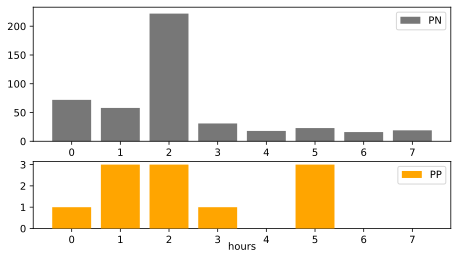

In [381]:

df = DFH.copy()

df['n'] = df['pn'] + df['pp']

fig2 = plt.figure(figsize=( 7.5, 4 ))
gs2 = fig2.add_gridspec(2, 1, height_ratios=(1, 0.5))

ax_n = fig2.add_subplot(gs2[0])
ax_p = fig2.add_subplot(gs2[1])

ax_n.bar(df.index, df['pn'], label='PN', color=mpcolors.to_rgba('#00000088'),      zorder=3)
ax_p.bar(df.index, df['pp'], label='PP', color='orange',   zorder=3)

ax_n.legend()
ax_p.legend()

ax_p.set_yticks(list(range(df['pp'].max() + 1)))

_ = ax_p.text(3.5, -1.0, 'hours', ha='center')
